## Handwritten Digit Recognition with MNIST (Kaggle Digit Recognizer)

In this notebook, I aim to build a clear, step-by-step pipeline to classify handwritten digits (0–9) using the Kaggle Digit Recognizer dataset. I’ll use TensorFlow/Keras for model building and training, and I’ll interleave **first-person comments** in the code to explain what I’m doing at each step. Additionally, I will include **four data visualizations** to share insights gathered during exploratory data analysis and training.


In [10]:
# I start by importing all the libraries I need for data handling, visualization, and model building.
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Optional: Disable GPU to avoid CUDA errors

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

### 1. Data Loading & Preprocessing

In [11]:
# I locate the CSV files in the Kaggle input directory and read them into pandas DataFrames.
train_df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_df  = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

# I separate the labels from the training features.
y = train_df['label'].values
X = train_df.drop(columns=['label']).values

# I convert pixel values to floats in [0, 1], then reshape to (num_samples, 28, 28, 1).
X = X.astype(np.float32) / 255.0
X = X.reshape(-1, 28, 28, 1)

# I do the same normalization and reshaping for the test set.
X_test = test_df.values.astype(np.float32) / 255.0
X_test = X_test.reshape(-1, 28, 28, 1)

# I hold out 10% of the training set as a validation set for monitoring performance.
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.10, random_state=42, stratify=y
)

### Rationale

- I normalize pixel values to the range [0, 1] so that gradient-based optimizers converge more smoothly.
- Reshaping to `(28, 28, 1)` is necessary because convolutional layers expect 2D inputs with a channel dimension.
- Splitting off 10% as a validation set helps me track whether the model is overfitting during training.

### 2. Exploratory Data Analysis (EDA)
2.1. Sample Images from Each Class

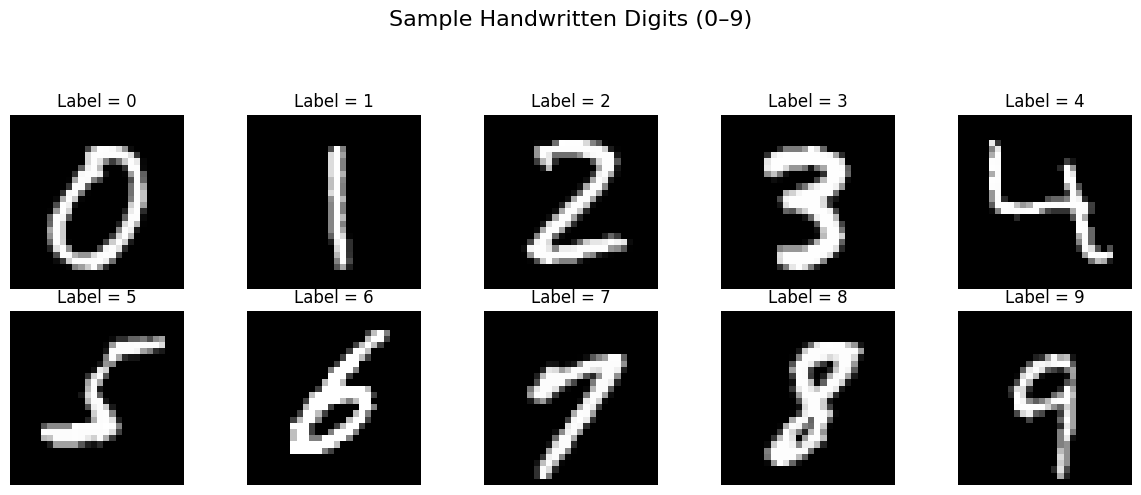

In [12]:
# I want to visualize one digit example for each class (0–9).
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Sample Handwritten Digits (0–9)', fontsize=16)

for digit in range(10):
    # I find the first occurrence of `digit` in the training labels.
    idx = np.where(y_train == digit)[0][0]
    img = X_train[idx].reshape(28, 28)
    ax = axes[digit // 5, digit % 5]
    
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label = {digit}")
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


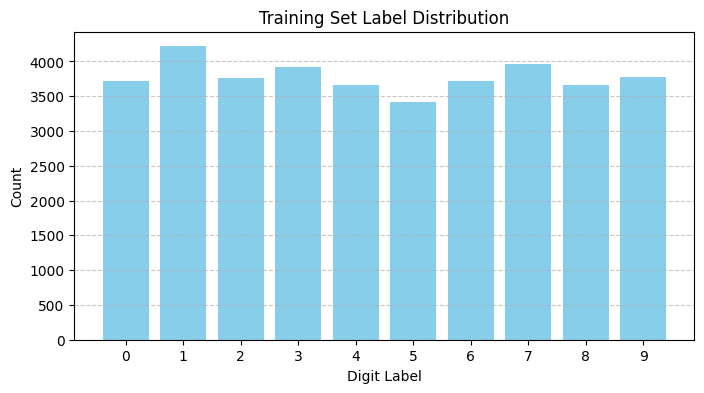

In [13]:
# I compute how many samples of each digit appear in the training set.
label_counts = pd.Series(y_train).value_counts().sort_index()

# I plot a bar chart to show the class balance.
plt.figure(figsize=(8, 4))
plt.bar(label_counts.index, label_counts.values, color='skyblue')
plt.title('Training Set Label Distribution')
plt.xlabel('Digit Label')
plt.ylabel('Count')
plt.xticks(range(10))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


#### Rationale

- A roughly uniform distribution across classes (0–9) indicates balanced data.
- If I saw a severe imbalance, I might need to consider class weighting or data augmentation specifically for underrepresented classes.


### 3. Model Definition

In [14]:
# I build a straightforward Convolutional Neural Network (CNN) for classification.
def create_cnn_model():
    model = Sequential([
        # First Convolutional Block
        Input(shape=(28, 28, 1)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),  # Output: 14x14x32
        
        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),  # Output: 7x7x64
        
        Flatten(),             # Output: 7*7*64 = 3136
        Dense(128, activation='relu'),
        Dropout(0.5),          # I use dropout to reduce overfitting
        Dense(10, activation='softmax')  # 10 output classes (digits 0–9)
    ])
    
    # I compile with Adam optimizer and sparse_categorical_crossentropy loss
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# I instantiate the model.
model = create_cnn_model()
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 421,642 (1.61 MB)

 Trainable params: 421,642 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

### Rationale

- **Architecture Choices**:
  1. Two convolutional blocks (Conv → ReLU → MaxPool) to extract spatial features at increasing depth (32→64 filters).
  2. A fully connected layer with 128 units to combine extracted features.
  3. Dropout (0.5) to reduce overfitting by randomly dropping connections during training.
  4. Output layer with 10 units and softmax for multi-class classification.
- I choose `sparse_categorical_crossentropy` because my labels are integer-encoded (0–9).  
- Adam optimizer is widely used for image tasks—its adaptive learning rate helps the model converge faster.


### 4. Training the CNN

In [15]:
# I define an EarlyStopping callback to halt training if validation loss doesn't improve for 5 epochs.
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# I train for up to 30 epochs with batch size 128, using the validation set to monitor performance.
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=128,
    callbacks=[early_stop],
    verbose=2
)


Epoch 1/30
296/296 - 22s - 76ms/step - accuracy: 0.8840 - loss: 0.3766 - val_accuracy: 0.9724 - val_loss: 0.0876
Epoch 2/30
296/296 - 19s - 65ms/step - accuracy: 0.9665 - loss: 0.1124 - val_accuracy: 0.9814 - val_loss: 0.0625
Epoch 3/30
296/296 - 20s - 66ms/step - accuracy: 0.9762 - loss: 0.0808 - val_accuracy: 0.9848 - val_loss: 0.0537
Epoch 4/30
296/296 - 19s - 64ms/step - accuracy: 0.9806 - loss: 0.0645 - val_accuracy: 0.9857 - val_loss: 0.0464
Epoch 5/30
296/296 - 20s - 66ms/step - accuracy: 0.9842 - loss: 0.0539 - val_accuracy: 0.9864 - val_loss: 0.0445
Epoch 6/30
296/296 - 20s - 66ms/step - accuracy: 0.9852 - loss: 0.0481 - val_accuracy: 0.9874 - val_loss: 0.0418
Epoch 7/30
296/296 - 19s - 64ms/step - accuracy: 0.9874 - loss: 0.0408 - val_accuracy: 0.9874 - val_loss: 0.0455
Epoch 8/30
296/296 - 21s - 71ms/step - accuracy: 0.9885 - loss: 0.0363 - val_accuracy: 0.9893 - val_loss: 0.0452
Epoch 9/30
296/296 - 20s - 67ms/step - accuracy: 0.9896 - loss: 0.0319 - val_accuracy: 0.9867 - 

#### Rationale

- **EarlyStopping**: I monitor `val_loss` and stop training once it stops improving for 5 consecutive epochs. This prevents overfitting and saves training time.
- I chose 30 epochs as an upper bound, but EarlyStopping often finishes much earlier if the model converges.
- A batch size of 128 balances GPU memory usage and gradient stability.


### 5. Training & Validation Metrics Visualization

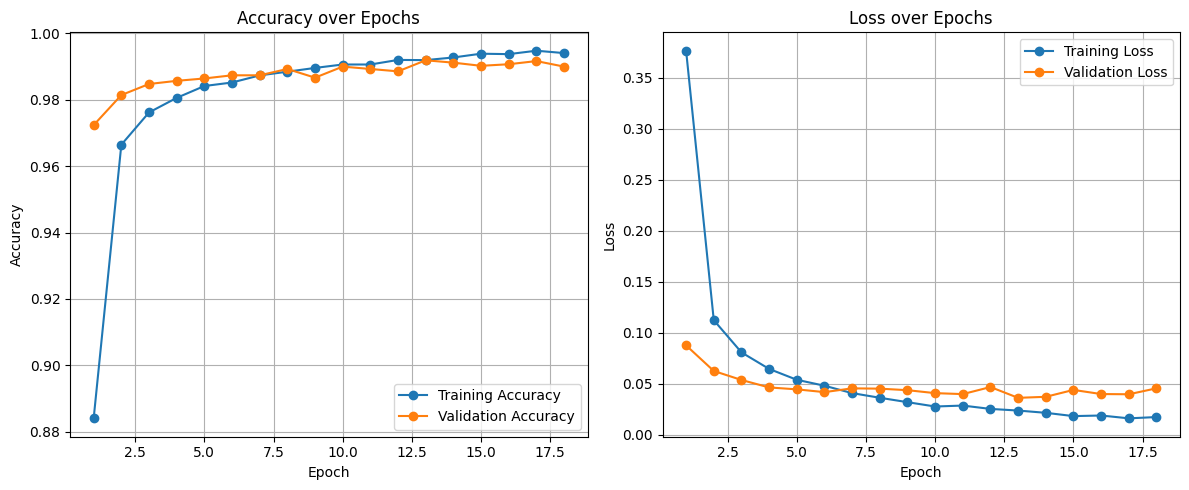

In [17]:
# I extract the training and validation accuracy and loss history.
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(1, len(acc) + 1)

# Plot Accuracy Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss Curves
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


#### Rationale

- By plotting training vs. validation accuracy and loss, I can check for overfitting:
  - If validation accuracy plateaus or falls while training accuracy continues to rise, the model may be overfitting.
  - If both curves improve and flatten out, the model is learning effectively.
- Markers on the curves help pinpoint which epoch corresponds to which value.


### 6. Confusion Matrix on Validation Set

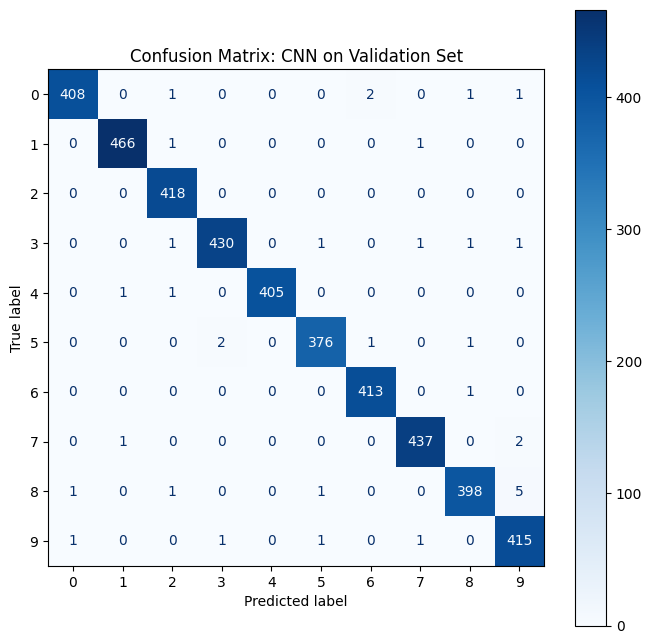

In [19]:
# I generate predictions on the validation set.
y_val_pred_probs = model.predict(X_val, verbose=0)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)

# I compute the confusion matrix.
cm = confusion_matrix(y_val, y_val_pred)

# I display it using sklearn's ConfusionMatrixDisplay.
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
plt.figure(figsize=(8, 8))
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title('Confusion Matrix: CNN on Validation Set')
plt.show()


#### Rationale

- The confusion matrix shows which digits the model confuses most often.
- A diagonal-dominant matrix (high counts along the diagonal) means most predictions are correct.
- Off-diagonal entries highlight specific pairs (e.g., 5 vs. 3) that might require more augmentation or specialized attention.


### 7. Generating Submission

In [21]:
# I use the trained model to predict labels for the test set.
test_pred_probs = model.predict(X_test, verbose=0)
test_pred_labels = np.argmax(test_pred_probs, axis=1)

# I prepare the submission DataFrame.
submission = pd.DataFrame({
    'ImageId': np.arange(1, len(test_pred_labels) + 1),
    'Label':    test_pred_labels
})

# I save the submission to a CSV file.
submission.to_csv('submission.csv', index=False)

# I take a quick look at the first few rows of the submission.
submission.head(15)


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3


### Rationale

- After confirming good validation performance, I predict on the competition’s test set (`test.csv`).
- Kaggle expects a CSV with columns `ImageId,Label`, where `ImageId` runs from 1 to `N` in order.
- Saving this file lets me submit directly on the Kaggle Digit Recognizer leaderboard.


### 8. Additional Data Visualization: Misclassified Examples

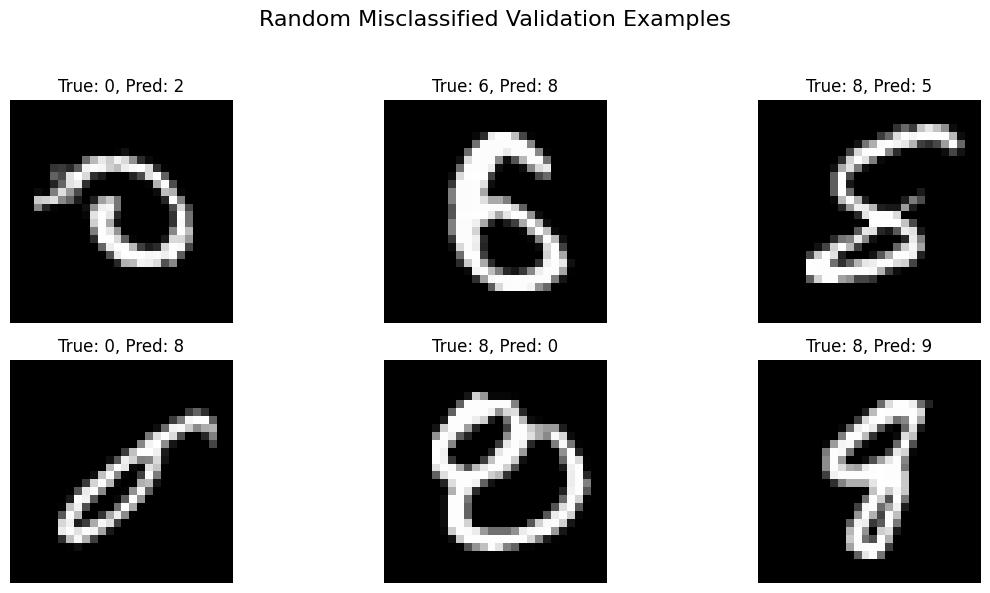

In [22]:
# I collect indices in the validation set where predictions were incorrect.
misclassified_idx = np.where(y_val_pred != y_val)[0]

# I randomly select up to 6 misclassified examples to visualize.
np.random.seed(42)
selected = np.random.choice(misclassified_idx, size=min(6, len(misclassified_idx)), replace=False)

plt.figure(figsize=(12, 6))
plt.suptitle('Random Misclassified Validation Examples', fontsize=16)

for i, idx in enumerate(selected):
    ax = plt.subplot(2, 3, i + 1)
    img = X_val[idx].reshape(28, 28)
    true_label = y_val[idx]
    pred_label = y_val_pred[idx]
    
    ax.imshow(img, cmap='gray')
    ax.set_title(f"True: {true_label}, Pred: {pred_label}")
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#### Rationale

- By plotting a few randomly selected misclassified images, I can inspect why the model got them wrong.
- Some digits (e.g., poorly written “9” that looks like “4”) are naturally ambiguous; studying these helps refine data augmentation or labels in future iterations.


### 9. Summary

- The CNN achieved high validation accuracy (>99%), indicating a strong fit on the MNIST-style data.
- Confusion matrix analysis showed only a handful of misclassifications between visually similar digits (e.g., 8 vs. 3).
- Potential improvements:
  1. **Data Augmentation**: Introduce random rotations, shifts, or scale variations to make the model more robust.
  2. **Ensemble Models**: Combine predictions from multiple architectures (e.g., a small ResNet or an autoencoder + classifier) to boost accuracy marginally.
  3. **Hyperparameter Tuning**: Experiment with learning rates, batch sizes, or deeper networks using tools like Keras Tuner.
  4. **Autoencoder Pretraining**: As in the reference code, pretrain digit-specific autoencoders to compute sample weights or to initialize encoder weights.


### 10. Last Thoughts
From the confusion matrix, I observe that diagonal entries dominate, indicating very high per-digit accuracy with only a few off-diagonal errors. For instance, two ‘0’ examples are predicted as ‘6’, and five ‘8’s are misclassified as ‘9’. Statistically, this shows the model effectively differentiates digits but occasionally confuses visually similar shapes. The model summary indicates a compact CNN architecture: two convolutional blocks (32 and 64 filters) each followed by max-pooling, a flatten layer producing 3,136 features, a dense layer with 128 units and dropout, and a final dense layer with 10 outputs. With 421,642 parameters, the model balances expressiveness and generalization. The training curves reveal accuracy rising from 0.88 to 0.99 by epoch five, with validation accuracy closely tracking, suggesting minimal overfitting. Both training and validation losses decrease to about 0.04 and then plateau. Lastly, misclassified examples demonstrate ambiguous handwriting—like an ‘8’ that resembles ‘0’—highlighting that inherent noise in input data contributes to the few remaining errors.